In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
keras = tf.keras

2023-09-16 23:24:58.911992: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_series(time,series,format="-",start=0,end=None,label=None):
    plt.plot(time[start:end], series[start:end],format,label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

    
def trend(time,slope=0):
    return slope*time
    
#seasonal Data
def seasonal_pattern(season_time):
    return np.where(season_time< 0.4,np.cos(season_time*2*np.pi),
                   1/np.exp(3*season_time))

def seasonality(time,period,amplitude=1,phase=0):
    season_time = ((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

# noise
def white_noise(time,noise_level=1,seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [3]:
time = np.arange(4*365+1)
slope = 0.05
baseline = 10
amplitude = 40

In [4]:
series = baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)
noise_level = 5
noise = white_noise(time,noise_level,seed=42)
series += noise

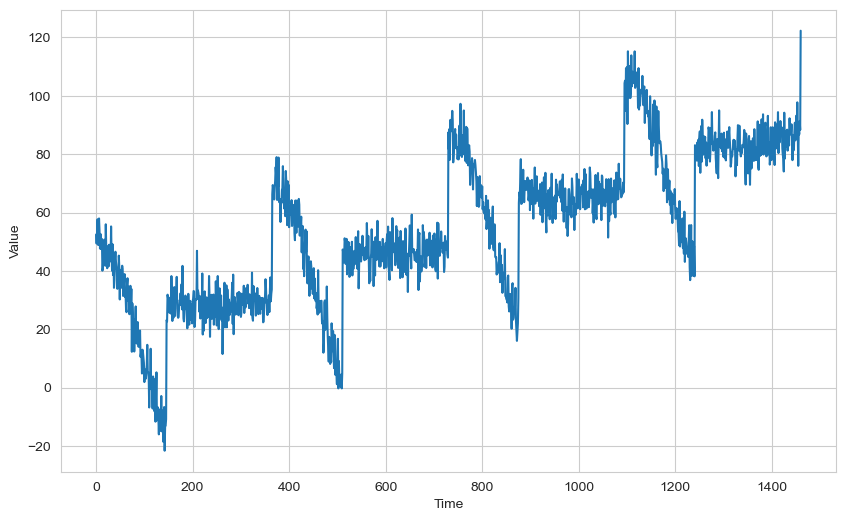

In [5]:
plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

In [6]:
def window_dataset(series,window_size,batch_size=32,shuffle_buffer=100):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1,shift=1,drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window:(window[:-1],window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [7]:
split_time = 1000
time_train = time[:split_time]
X_train = series[:split_time]
time_valid = time[split_time:]
X_valid = series[split_time:]

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30

In [9]:
train_set = window_dataset(X_train,window_size)

2023-09-16 23:26:13.017289: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
valid_set = window_dataset(X_valid,window_size)

In [11]:
model = keras.models.Sequential([
    keras.layers.Dense(1,input_shape=[window_size])
])

In [13]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)
model.compile(loss=keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])

In [14]:
model.fit(train_set,epochs=10,validation_data=valid_set)

Epoch 1/10
31/31 [==============================] - 1s 29ms/step - loss: 48.2177 - mae: 48.7160 - val_loss: 23.3928 - val_mae: 23.8928
Epoch 2/10
31/31 [==============================] - 0s 5ms/step - loss: 14.6711 - mae: 15.1626 - val_loss: 9.6376 - val_mae: 10.1264
Epoch 3/10
31/31 [==============================] - 0s 5ms/step - loss: 10.1483 - mae: 10.6362 - val_loss: 9.6205 - val_mae: 10.1086
Epoch 4/10
31/31 [==============================] - 0s 5ms/step - loss: 9.7825 - mae: 10.2733 - val_loss: 9.8031 - val_mae: 10.2913
Epoch 5/10
31/31 [==============================] - 0s 5ms/step - loss: 9.4879 - mae: 9.9709 - val_loss: 9.2252 - val_mae: 9.7162
Epoch 6/10
31/31 [==============================] - 0s 5ms/step - loss: 9.3351 - mae: 9.8229 - val_loss: 9.4122 - val_mae: 9.9011
Epoch 7/10
31/31 [==============================] - 0s 5ms/step - loss: 9.1100 - mae: 9.5983 - val_loss: 8.7848 - val_mae: 9.2699
Epoch 8/10
31/31 [==============================] - 0s 5ms/step - loss: 8.974

In [15]:
# Tunning
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30

In [16]:
train_set = window_dataset(X_train,window_size)

In [17]:
model = keras.models.Sequential([
    keras.layers.Dense(1,input_shape=[window_size])
])

In [18]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6*10**(epoch/30))

In [19]:
optimizer = keras.optimizers.SGD(learning_rate=1e-6,momentum=0.9)

In [20]:
model.compile(loss=keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])

In [21]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 4ms/step - loss: 34.2727 - mae: 34.7720 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 20.0382 - mae: 20.5351 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 10.7419 - mae: 11.2301 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 10.2920 - mae: 10.7789 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 10.2704 - mae: 10.7589 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 10.2365 - mae: 10.7257 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 10.2256 - mae: 10.7142 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 10.1968 - mae: 10.6861 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 10.1874 - mae: 10.6748 

Epoch 74/100
31/31 [==============================] - 0s 2ms/step - loss: 10.4954 - mae: 10.9870 - lr: 2.7123e-04
Epoch 75/100
31/31 [==============================] - 0s 2ms/step - loss: 6.0201 - mae: 6.5036 - lr: 2.9286e-04
Epoch 76/100
31/31 [==============================] - 0s 2ms/step - loss: 6.4733 - mae: 6.9588 - lr: 3.1623e-04
Epoch 77/100
31/31 [==============================] - 0s 2ms/step - loss: 14.1010 - mae: 14.5939 - lr: 3.4145e-04
Epoch 78/100
31/31 [==============================] - 0s 2ms/step - loss: 22.2318 - mae: 22.7282 - lr: 3.6869e-04
Epoch 79/100
31/31 [==============================] - 0s 2ms/step - loss: 12.1229 - mae: 12.6128 - lr: 3.9811e-04
Epoch 80/100
31/31 [==============================] - 0s 2ms/step - loss: 15.4689 - mae: 15.9638 - lr: 4.2987e-04
Epoch 81/100
31/31 [==============================] - 0s 2ms/step - loss: 18.3432 - mae: 18.8336 - lr: 4.6416e-04
Epoch 82/100
31/31 [==============================] - 0s 3ms/step - loss: 35.6562 - mae: 36.

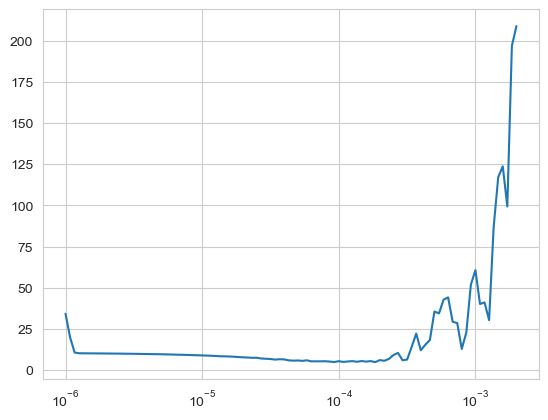

In [22]:
plt.semilogx(history.history['lr'],history.history['loss'])
#plt.axis(1e-6,1e-3,0,20)
plt.show()

In [23]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30

In [24]:
train_set = window_dataset(X_train,window_size)
valid_set = window_dataset(X_valid,window_size)

In [25]:
model = keras.models.Sequential([
    keras.layers.Dense(1,input_shape=[window_size])
])

In [26]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)
model.compile(loss=keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])

In [27]:
early_stooping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set,epochs=500,validation_data=valid_set,callbacks=[early_stooping])

Epoch 1/500
31/31 [==============================] - 1s 9ms/step - loss: 71.0003 - mae: 71.5003 - val_loss: 11.0978 - val_mae: 11.5889
Epoch 2/500
31/31 [==============================] - 0s 5ms/step - loss: 13.8033 - mae: 14.2968 - val_loss: 10.6915 - val_mae: 11.1849
Epoch 3/500
31/31 [==============================] - 0s 5ms/step - loss: 7.4658 - mae: 7.9517 - val_loss: 7.2253 - val_mae: 7.7125
Epoch 4/500
31/31 [==============================] - 0s 5ms/step - loss: 7.2446 - mae: 7.7297 - val_loss: 7.2610 - val_mae: 7.7490
Epoch 5/500
31/31 [==============================] - 0s 5ms/step - loss: 7.2120 - mae: 7.6989 - val_loss: 7.0975 - val_mae: 7.5857
Epoch 6/500
31/31 [==============================] - 0s 5ms/step - loss: 7.0876 - mae: 7.5749 - val_loss: 7.3598 - val_mae: 7.8456
Epoch 7/500
31/31 [==============================] - 0s 5ms/step - loss: 7.0343 - mae: 7.5151 - val_loss: 7.4711 - val_mae: 7.9587
Epoch 8/500
31/31 [==============================] - 0s 6ms/step - loss: 7.

31/31 [==============================] - 0s 5ms/step - loss: 5.1618 - mae: 5.6367 - val_loss: 5.2865 - val_mae: 5.7586
Epoch 64/500
31/31 [==============================] - 0s 4ms/step - loss: 5.1681 - mae: 5.6502 - val_loss: 5.2938 - val_mae: 5.7714
Epoch 65/500
31/31 [==============================] - 0s 5ms/step - loss: 5.1513 - mae: 5.6296 - val_loss: 5.2967 - val_mae: 5.7689
Epoch 66/500
31/31 [==============================] - 0s 5ms/step - loss: 5.0935 - mae: 5.5741 - val_loss: 5.2650 - val_mae: 5.7359
Epoch 67/500
31/31 [==============================] - 0s 5ms/step - loss: 5.0733 - mae: 5.5512 - val_loss: 5.2804 - val_mae: 5.7545
Epoch 68/500
31/31 [==============================] - 0s 5ms/step - loss: 5.0352 - mae: 5.5169 - val_loss: 5.4457 - val_mae: 5.9268
Epoch 69/500
31/31 [==============================] - 0s 5ms/step - loss: 5.0444 - mae: 5.5217 - val_loss: 5.1962 - val_mae: 5.6694
Epoch 70/500
31/31 [==============================] - 0s 5ms/step - loss: 5.0100 - mae: 5

Epoch 125/500
31/31 [==============================] - 0s 5ms/step - loss: 4.7090 - mae: 5.1897 - val_loss: 4.9379 - val_mae: 5.4174
Epoch 126/500
31/31 [==============================] - 0s 5ms/step - loss: 4.5613 - mae: 5.0384 - val_loss: 4.7156 - val_mae: 5.1914
Epoch 127/500
31/31 [==============================] - 0s 5ms/step - loss: 4.5369 - mae: 5.0134 - val_loss: 4.7908 - val_mae: 5.2685
Epoch 128/500
31/31 [==============================] - 0s 5ms/step - loss: 4.5159 - mae: 4.9907 - val_loss: 4.8296 - val_mae: 5.3069
Epoch 129/500
31/31 [==============================] - 0s 5ms/step - loss: 4.5064 - mae: 4.9807 - val_loss: 4.7008 - val_mae: 5.1761
Epoch 130/500
31/31 [==============================] - 0s 5ms/step - loss: 4.4961 - mae: 4.9727 - val_loss: 4.7286 - val_mae: 5.2019
Epoch 131/500
31/31 [==============================] - 0s 5ms/step - loss: 4.4941 - mae: 4.9721 - val_loss: 4.7794 - val_mae: 5.2566
Epoch 132/500
31/31 [==============================] - 0s 5ms/step - 

31/31 [==============================] - 0s 5ms/step - loss: 4.3985 - mae: 4.8755 - val_loss: 4.6150 - val_mae: 5.1000
Epoch 187/500
31/31 [==============================] - 0s 5ms/step - loss: 4.3784 - mae: 4.8538 - val_loss: 4.5871 - val_mae: 5.0592
Epoch 188/500
31/31 [==============================] - 0s 5ms/step - loss: 4.4217 - mae: 4.8989 - val_loss: 4.6232 - val_mae: 5.0979
Epoch 189/500
31/31 [==============================] - 0s 5ms/step - loss: 4.3443 - mae: 4.8171 - val_loss: 4.5279 - val_mae: 4.9967
Epoch 190/500
31/31 [==============================] - 0s 5ms/step - loss: 4.3454 - mae: 4.8205 - val_loss: 4.6904 - val_mae: 5.1674
Epoch 191/500
31/31 [==============================] - 0s 5ms/step - loss: 4.3491 - mae: 4.8246 - val_loss: 4.5644 - val_mae: 5.0473
Epoch 192/500
31/31 [==============================] - 0s 5ms/step - loss: 4.3383 - mae: 4.8141 - val_loss: 4.5575 - val_mae: 5.0293
Epoch 193/500
31/31 [==============================] - 0s 5ms/step - loss: 4.3674 -

In [28]:
def model_forcast(model,series,window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda w:w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [29]:
lin_forecast = model_forcast(model,series[split_time-window_size:-1],window_size)[:,0]

15/15 [==============================] - 0s 4ms/step


In [30]:
lin_forecast

array([ 64.48259 ,  68.69374 ,  71.05912 ,  67.78376 ,  64.16135 ,
        68.70981 ,  65.63763 ,  67.14045 ,  69.30673 ,  69.20948 ,
        65.52571 ,  68.49587 ,  68.25157 ,  70.65642 ,  66.373955,
        71.65615 ,  67.34456 ,  66.733345,  64.48034 ,  65.46851 ,
        64.36297 ,  66.27536 ,  64.17898 ,  66.53574 ,  68.052376,
        71.14295 ,  69.48848 ,  68.689766,  68.260574,  68.067474,
        66.07242 ,  64.10022 ,  61.185505,  64.87415 ,  64.33011 ,
        64.99659 ,  67.856255,  64.29192 ,  62.8374  ,  64.356964,
        65.96103 ,  70.56768 ,  66.75314 ,  69.104256,  66.58885 ,
        67.252495,  68.702126,  68.237465,  65.61245 ,  66.94788 ,
        68.63128 ,  69.9224  ,  65.98904 ,  67.1659  ,  68.349205,
        66.28564 ,  64.72486 ,  65.76087 ,  68.1082  ,  66.92366 ,
        65.48885 ,  70.49969 ,  62.16691 ,  64.7154  ,  64.13226 ,
        62.998295,  60.65938 ,  63.42803 ,  64.60362 ,  64.630714,
        65.25769 ,  67.03761 ,  67.16906 ,  67.702446,  64.204

In [31]:
lin_forecast.shape

(461,)

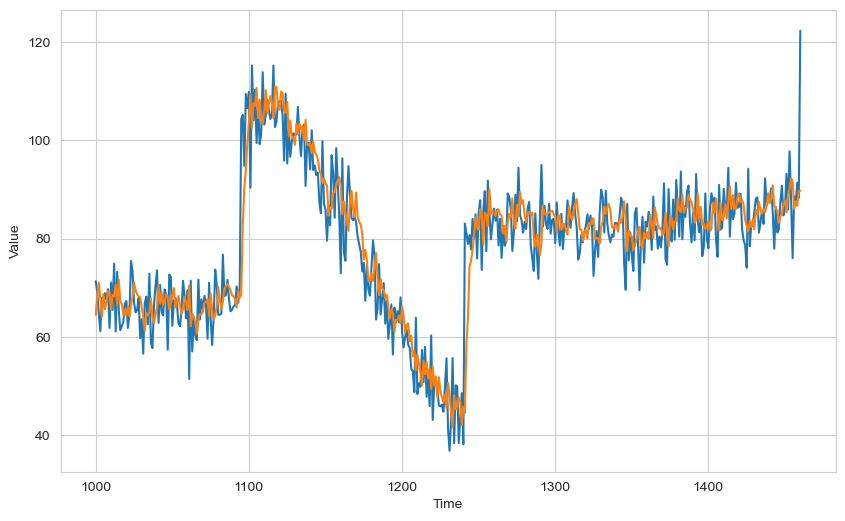

In [32]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,lin_forecast)

In [33]:
# Dense Model 
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30
train_set = window_dataset(X_train,window_size)

In [34]:
model = keras.models.Sequential([
    keras.layers.Dense(10,activation='relu',input_shape=[window_size]),
    keras.layers.Dense(10,activation='relu'),
    keras.layers.Dense(1)
])

In [35]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7*10**(epoch/20))

In [36]:
optimizer = keras.optimizers.SGD(learning_rate=1e-7,momentum=0.9)
model.compile(loss=keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 3ms/step - loss: 34.9053 - mae: 35.4046 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 34.7174 - mae: 35.2164 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 34.4861 - mae: 34.9850 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 34.2189 - mae: 34.7176 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 33.9094 - mae: 34.4081 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 33.5529 - mae: 34.0515 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 33.1406 - mae: 33.6394 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 32.6623 - mae: 33.1612 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 32.0996 - mae: 32.5985 

Epoch 74/100
31/31 [==============================] - 0s 3ms/step - loss: 5.7686 - mae: 6.2527 - lr: 4.4668e-04
Epoch 75/100
31/31 [==============================] - 0s 2ms/step - loss: 5.0830 - mae: 5.5610 - lr: 5.0119e-04
Epoch 76/100
31/31 [==============================] - 0s 3ms/step - loss: 7.0013 - mae: 7.4850 - lr: 5.6234e-04
Epoch 77/100
31/31 [==============================] - 0s 3ms/step - loss: 4.9879 - mae: 5.4679 - lr: 6.3096e-04
Epoch 78/100
31/31 [==============================] - 0s 3ms/step - loss: 6.3567 - mae: 6.8422 - lr: 7.0795e-04
Epoch 79/100
31/31 [==============================] - 0s 3ms/step - loss: 6.7398 - mae: 7.2226 - lr: 7.9433e-04
Epoch 80/100
31/31 [==============================] - 0s 3ms/step - loss: 6.3811 - mae: 6.8661 - lr: 8.9125e-04
Epoch 81/100
31/31 [==============================] - 0s 2ms/step - loss: 17.1664 - mae: 17.6594 - lr: 0.0010
Epoch 82/100
31/31 [==============================] - 0s 2ms/step - loss: 9.6543 - mae: 10.1417 - lr: 0.00

(1e-07, 0.005, 0.0, 30.0)

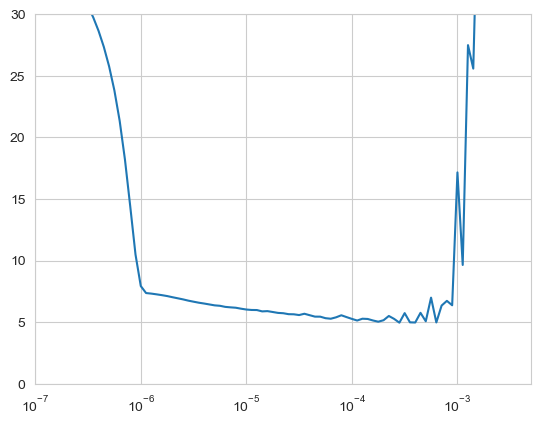

In [37]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-7,5e-3,0,30])

In [38]:
# tunning
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30
train_set = window_dataset(X_train,window_size)

In [39]:
model = keras.models.Sequential([
    keras.layers.Dense(10,activation='relu',input_shape=[window_size]),
    keras.layers.Dense(10,activation='relu'),
    keras.layers.Dense(1)
])

In [40]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [41]:
early_stooping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set,epochs=500,
         validation_data=valid_set,
         callbacks=[early_stooping])

Epoch 1/500
31/31 [==============================] - 1s 9ms/step - loss: 41.2872 - mae: 41.7865 - val_loss: 56.2885 - val_mae: 56.7885
Epoch 2/500
31/31 [==============================] - 0s 6ms/step - loss: 16.2659 - mae: 16.7625 - val_loss: 10.4403 - val_mae: 10.9350
Epoch 3/500
31/31 [==============================] - 0s 5ms/step - loss: 8.0845 - mae: 8.5726 - val_loss: 7.5237 - val_mae: 8.0106
Epoch 4/500
31/31 [==============================] - 0s 5ms/step - loss: 6.9473 - mae: 7.4283 - val_loss: 6.5624 - val_mae: 7.0416
Epoch 5/500
31/31 [==============================] - 0s 5ms/step - loss: 6.7126 - mae: 7.1931 - val_loss: 6.3218 - val_mae: 6.7940
Epoch 6/500
31/31 [==============================] - 0s 5ms/step - loss: 6.5927 - mae: 7.0744 - val_loss: 6.2465 - val_mae: 6.7212
Epoch 7/500
31/31 [==============================] - 0s 5ms/step - loss: 6.5158 - mae: 6.9978 - val_loss: 6.1057 - val_mae: 6.5833
Epoch 8/500
31/31 [==============================] - 0s 5ms/step - loss: 6.

In [42]:
dense_forcast = model_forcast(model,
                             series[split_time-window_size:-1],window_size)[:,0]

15/15 [==============================] - 0s 5ms/step


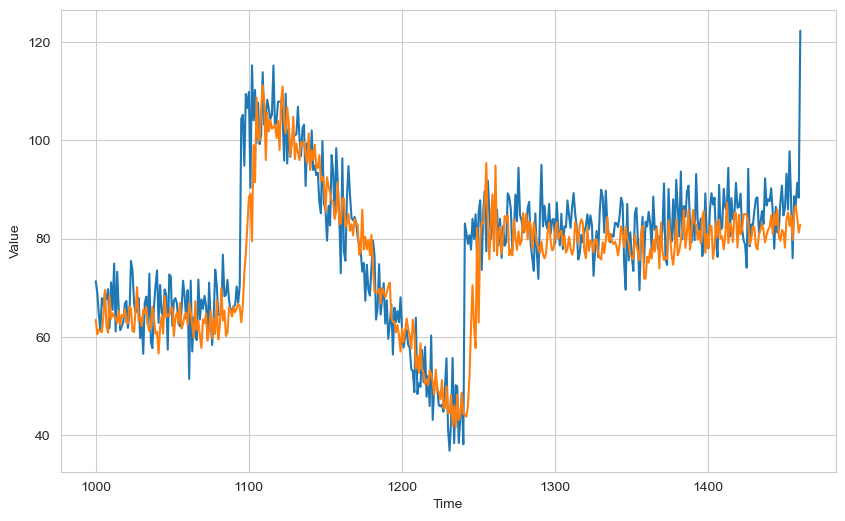

In [43]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,dense_forcast)

In [44]:
keras.metrics.mean_absolute_error(X_valid,dense_forcast).numpy()

5.9463367